# Purpose: testing an early iteration of my model that idd not utilize differenced images

In [2]:
from keras.models import load_model
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
from astropy.io import fits
from astropy import wcs
import skimage
import random
import scipy.stats as stats
import pickle as pkl
from functools import partial
from multiprocessing import Pool
import cupy as cp
from cupyx.scipy.ndimage.filters import convolve
import tensorflow as tf
import innvestigate
import reproject
import astroscrappy
import subprocess
import sep
from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [3]:
# generated from generate_streak_distribution.py
params_gamma_width = [4.79235037, 11.40523025, 1.64361626]
params_gamma_amplitude = [1.09717868, 1.99999993, 3.7169828]
params_gamma_length = [4.16396709, 8.0180058, 2.68969172]

gain = 6.2

amp_factor = 1.5


def gaussian(x, offset, std, amp):
    return amp * np.exp(-np.power(x - offset, 2.) / (2 * np.power(std, 2.)))


def gaussian_streak(width, offset, std, amp, bkg):
    dist = gaussian(np.arange(width), offset, std, amp) + bkg
    return dist


def implant_random_streak(image):

    image = np.copy(image)

    while True:
        std = stats.gamma.rvs(*params_gamma_width) * 0.05
        width = std * 10

        if random.random() < 0.7:
            length = stats.gamma.rvs(*params_gamma_length)
        else:
            length = np.random.random() * 30 + 10

        # use 2*std, which is "real" width
        if length / (std * 2) > 2 and length > 10 and width > 0:
            break

    streak = np.repeat(np.array([gaussian_streak(width, width / 2, std, 1, 0)]).T, length, axis=1)
    rotation = np.random.uniform(0, 360)
    streak = skimage.transform.rotate(streak, rotation, resize=True, order=3)

    y_len, x_len = image.shape
    y_len_streak, x_len_streak = streak.shape
    x_streak = np.random.randint(0, x_len - x_len_streak)
    y_streak = np.random.randint(0, y_len - y_len_streak)

    print(y_streak, x_streak)
    
    amp_min = np.std(image[y_streak:y_streak + y_len_streak, x_streak:x_streak + x_len_streak]) * amp_factor
#     amp_min = max(np.std(image), np.std(image[y_streak:y_streak + y_len_streak, x_streak:x_streak + x_len_streak])) * amp_factor

    if random.random() < 0.9:
        amplitude = amp_min * (1 + abs(np.random.randn()))
    else:
        amplitude = (np.random.random() * 5) * amp_min

    streak *= amplitude

    # add shot noise
    streak = np.random.poisson(streak * gain)

    streak = streak / gain
    shape = streak.shape
    image[y_streak:y_streak + shape[0], x_streak:x_streak + shape[1]] += streak

    return image

In [75]:
contrast = 0.25
size = 80


def linear_regression(x, y, w):
    B = cp.matmul(x.T, cp.expand_dims(cp.multiply(w, y), -1))
    B2 = cp.linalg.inv(cp.matmul(x.T, cp.multiply(cp.expand_dims(w, -1), x)))
    return cp.matmul(B2, B)[..., 0]


def weighted_std(values, weights):
    average = cp.expand_dims(cp.average(values, weights=weights, axis=-1), -1)
    # Fast and numerically precise:
    variance = cp.average((values - average) ** 2, weights=weights, axis=-1)
    return cp.sqrt(variance)


# for some reason CuPy just doesn't have median function
def get_median(arr):
    size = arr.shape[-1]
    return (arr[:, size // 2] + arr[:, size // 2 + 1]) / 2


def normalize_cuda(arr, nsamples=size*size//12):
    arr = cp.array(arr)

    values = cp.reshape(arr, (len(arr), size * size))
    stride = (size * size) // nsamples

    samples = cp.array(values[::, ::stride][::, :nsamples])
    samples.sort()

    npix = nsamples
    nimage = len(arr)

    x = cp.arange(npix)
    x_fit = cp.stack((x, cp.ones(x.shape)), axis=-1)

    # pixels mask used in k-sigma clipping
    goodpix = cp.ones((nimage, npix))

    ngrow = max(1, int(npix * 0.01))
    kernel = cp.ones((1, ngrow))

    for niter in range(3):
        n_samples = cp.sum(goodpix, axis=-1, keepdims=True)
        fit = linear_regression(x_fit, samples, goodpix)
        slope = fit[:, 0]
        intercept = fit[:, 1]
        
        fitted = cp.expand_dims(slope, 1) * cp.expand_dims(x, 0) + cp.expand_dims(intercept, 1)

        # Subtract fitted line from the data array
        flat = samples - fitted

        # Compute the k-sigma rejection threshold
        threshold = cp.expand_dims(2.5 * weighted_std(flat, goodpix), -1)

        # Detect and reject pixels further than k*sigma from the
        # fitted line
        goodpix[(flat < - threshold) | (flat > threshold)] = 0

        goodpix = 1 - cp.clip(convolve(1 - goodpix, kernel), 0, 1)

    if contrast > 0:
        slope = slope / contrast
    center_pixel = (npix - 1) // 2
    median = get_median(samples)

    vmin = median - (center_pixel - 1) * slope
    vmax = median + (npix - center_pixel) * slope
    
    old_min = cp.min(samples, axis=1)
    old_max = cp.max(samples, axis=1)
    
    vmin = cp.maximum(vmin, old_min)
    vmax = cp.minimum(vmax, old_max)

    vmin = cp.reshape(vmin, (len(arr), 1, 1))
    vmax = cp.reshape(vmax, (len(arr), 1, 1))

    arr -= vmin
    arr /= vmax - vmin

    return (cp.clip(arr, 0, 1) - 0.5) * 2


def normalize(arr, samples=size * size // 4):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)
    return (arr - 0.5) * 2

In [1]:
# FPR = 0.001037037, TPR = 0.974388889
model = load_model("/home/fwang/wandb/run-20200418_020552-8c1w6m3j/model-best.h5")
# MODEL FOR NORMALIZATION WITH ZSCALE
# model = load_model("/home/fwang/wandb/run-20200208_034755-ve68xd4n/model-best.h5")
# MODEL FOR OLDER GPU ACCELERATED NORMALIZATION THAT WAS NOT ACCURATE
# model = load_model("/home/fwang/wandb/run-20200224_230632-sx0eb942/model-best.h5")

NameError: name 'load_model' is not defined

In [99]:
filenames = glob.glob("/media/rd1/ztf_neos/training_examples/aligned/*")

In [100]:
filename = np.random.choice(filenames)
sci, ref = np.load(filename)

In [104]:
sci = implant_random_streak(sci)

2240 215


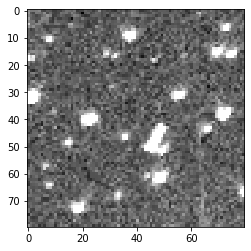

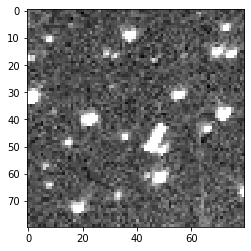

In [107]:
contrast = 0.3
y = 2240
x = 215
plt.imshow(normalize(sci[y-size//2:y+size//2, x-size//2:x+size//2], samples=20000), cmap="gray")
plt.figure()
plt.imshow(normalize_cuda([sci[y-size//2:y+size//2, x-size//2:x+size//2]], nsamples=size*size//8).get()[0], cmap="gray")

In [113]:
def convert_sci_to_ref(file):
    filename = file.split("/")[-1]
    return "/media/rd1/ztf_neos/fits_files_resampled/" + filename[:-len("sciimg.resamp.fits")] + "refimg.resamp.fits"


# align the reference file to the science, returns science and reference
def swarp_align(sci_file, ref_file):
    header = fits.getheader(sci_file)
    with open("coadd.head", "w") as f:
        f.write(repr(header) + "\nEND     ")
    subprocess.run(["swarp", ref_file, "-c", "/home/fwang/swarp.conf"], cwd="/home/fwang/")
    filename_ref = ref_file.split("/")[-1]
    return [fits.getdata(sci_file),
            fits.getdata("/media/rd1/ztf_neos/aligned/" + filename_ref[:-len(".fits")] + ".resamp.fits")]
#             fits.getdata("/media/rd1/ztf_neos/aligned/" + filename_ref[:-len(".fits")] + ".resamp.weight.fits")]


filenames = glob.glob("/media/rd1/ztf_neos/fits_files_resampled/*_sciimg.resamp.fits")
filename_pairs = [[file, convert_sci_to_ref(file)] for file in filenames]

In [11]:
%%time
sci_file, ref_file = random.choice(filename_pairs)
sci, ref = swarp_align(sci_file, ref_file)

CPU times: user 10.2 ms, sys: 36.9 ms, total: 47.2 ms
Wall time: 1.88 s


In [108]:
%%time
y_len, x_len = sci.shape
images = []
bounds = []
for i in range(0, y_len, 50):
    for j in range(0, x_len, 50):
        if j + size >= x_len or i + size >= y_len:
            continue

        crop_sci = sci[i:i+80, j:j+80]
        crop_ref = ref[i:i+80, j:j+80]
#         crop_ref_weight = ref_weight[i:i+80, j:j+80]

        if np.sum(np.abs(crop_sci) <= 1e-4) >= 10 or np.sum(np.abs(crop_ref) <= 1e-4) >= 10 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
            continue
            
#         if np.sum(crop_ref_weight == 0) >= 10:
#             continue

        images.append([crop_sci, crop_ref])
        bounds.append([[j,j+80],[i,i+80]])

CPU times: user 252 ms, sys: 3.14 ms, total: 255 ms
Wall time: 253 ms


In [109]:
%%time
images_gpu = cp.array(images, dtype=cp.float64)
images_gpu = cp.reshape(images_gpu, (-1, 80, 80))

CPU times: user 161 ms, sys: 72.7 ms, total: 234 ms
Wall time: 232 ms


In [112]:
%%time
norm_images = normalize_cuda(images_gpu, size * size // 8)

CPU times: user 1.08 s, sys: 0 ns, total: 1.08 s
Wall time: 1.07 s


In [123]:
%%time
norm_images = cp.reshape(norm_images, (-1, 2, size, size)).get()

CPU times: user 108 ms, sys: 48.3 ms, total: 156 ms
Wall time: 154 ms


In [124]:
%%time
norm_images_transpose = cp.transpose(norm_images, [0, 2, 3, 1])
preds = model.predict(norm_images_transpose)[:, 0]

CPU times: user 1.13 s, sys: 116 ms, total: 1.25 s
Wall time: 959 ms


[3430 1151 1149 1148 1147 1146 1145 1144 1143 1142 1141 1140 1139 1138
 1137 1136 1135 1134 1133 1132]
[0. 0. 0. ... 0. 0. 0.]
0
3431


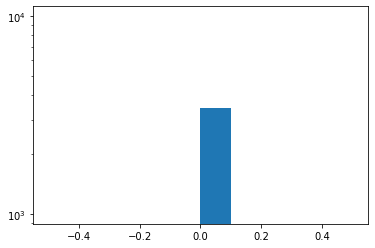

In [125]:
print(np.argsort(preds)[::-1][:20])
print(preds[np.argsort(preds)[::-1]])
plt.hist(preds[np.argsort(preds)[::-1]])
print(len(preds[preds > 0.95]))
print(len(preds))
plt.yscale('log', nonposy='clip')

In [110]:
top_preds = np.argsort(preds)[::-1]

In [83]:
print(sci_file)

NameError: name 'sci_file' is not defined

0.0
[[1900, 1980], [2900, 2980]]


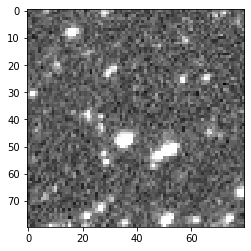

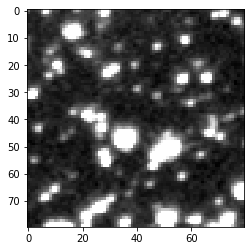

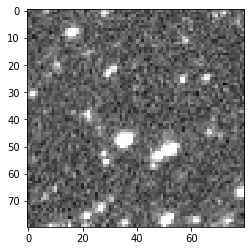

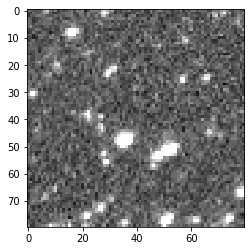

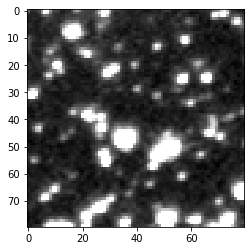

In [119]:
i = 0
index = top_preds[i]
print(preds[top_preds[i]])
print(bounds[index])

plt.imshow(norm_images[index][0], cmap="gray")
plt.figure()
plt.imshow(norm_images[index][1], cmap="gray")
plt.figure()
# plt.imshow(ref[bounds[index][1][0]:bounds[index][1][1], bounds[index][0][0]:bounds[index][0][1]], cmap="gray")
# plt.figure()
# print(np.sum(np.abs(ref[bounds[index][1][0]:bounds[index][1][1], bounds[index][0][0]:bounds[index][0][1]]) < 1e-3))
# print(ref[bounds[index][1][0]:bounds[index][1][1], bounds[index][0][0]:bounds[index][0][1]])
plt.imshow(normalize(astroscrappy.detect_cosmics(images[index][0])[1]), cmap="gray")
plt.figure()
plt.imshow(normalize(images[index][0]), cmap="gray")
plt.figure()
plt.imshow(normalize(images[index][1]), cmap="gray")

array([[[[ 5.93008614,  0.5520274 ,  3.33016944, ..., -1.88567138,
           3.6543529 ,  3.9155643 ],
         [ 2.14409828,  3.31636333, -2.39343667, ...,  2.90840101,
           3.05586362, -2.98742676],
         [ 0.61767405, -6.34566975,  2.9833076 , ...,  1.89887166,
          -2.72484684, -0.60821539],
         ...,
         [ 3.22318292,  2.15871906,  4.57283545, ..., -1.98007989,
          -2.2110889 ,  1.11803806],
         [-3.99566269,  1.27374697,  0.9157815 , ...,  1.65717936,
           0.48473397,  2.06393933],
         [ 2.3463161 , -1.69187355,  1.50454783, ..., -1.10870886,
          -4.01086664, -0.44440341]],

        [[-1.97733819, -0.8140229 , -0.62503868, ..., -2.5348618 ,
          -0.07864448, -1.29148889],
         [ 1.09103465,  0.17747748,  0.92444599, ..., -1.26660001,
          -0.4849427 ,  1.60535216],
         [ 2.31710362,  1.34779561,  1.71318209, ...,  0.4151985 ,
           2.32945895,  0.86060715],
         ...,
         [ 1.49225295, -1.34941912

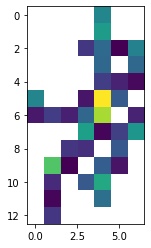

<Figure size 432x288 with 0 Axes>

In [168]:
check_images(np.array([images[index]]))

In [59]:
top_preds = np.where(preds > 0.6)[0]

In [60]:
top_images = np.array(images)[top_preds]

In [346]:
print(len(top_images))
images_filtered = check_images(top_images)

8


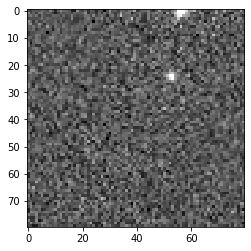

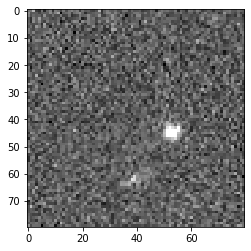

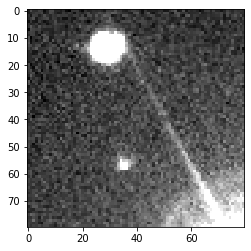

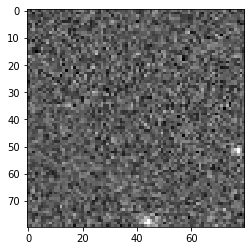

In [347]:
for i in range(len(images_filtered)):
    plt.figure()
    plt.imshow(normalize(images_filtered[i][0]), cmap="gray")

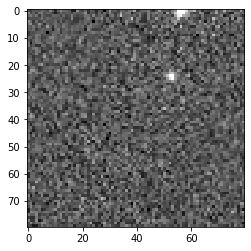

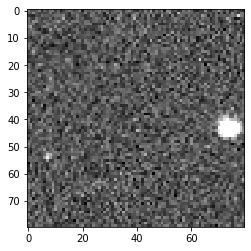

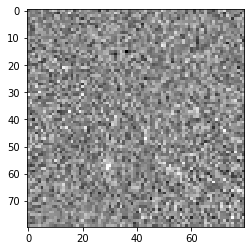

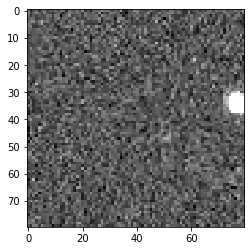

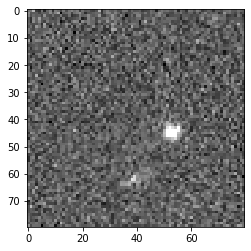

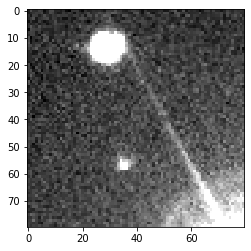

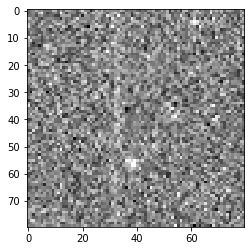

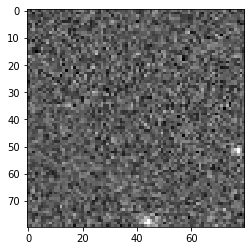

In [348]:
for i in range(len(top_images)):
    plt.figure()
    plt.imshow(normalize(top_images[i][0]), cmap="gray")

In [54]:
def distance(c1, c2):
    return ((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2) ** 0.5


def check_images(images):
    works = []
    thresholds = [1.0, 1.3, 1.5]
    for image, _ in images:
        if image.size == 0:
            works.append(False)
            continue

        bkg = sep.Background(np.array(image))
        image = image - bkg

        did_work = False
        for threshold in thresholds:

            threshold = bkg.rms() * threshold
        #     threshold = detect_threshold(image, 1.5)
        #     threshold = skimage.filters.thresholding.threshold_(image)

            segm = detect_sources(image, threshold, 20, connectivity=4)

            try:
                segm = deblend_sources(image, segm, 20, connectivity=4)
            except:
                break

            info = source_properties(image, segm)

            best_streak = None

            for obj in info:
                cutout = obj.data_cutout_ma
                elongation = obj.elongation
                bbox = [obj.bbox.ixmin, obj.bbox.ixmax, obj.bbox.iymin, obj.bbox.iymax]
                bbox = np.array(bbox, np.float64)
                length = distance(cutout.shape, (0,0))
                if length > 5 and elongation > 2:
                    did_work = True
                    break

            if did_work:
                break
        works.append(did_work)

    return images[works]

In [61]:
top_images = [(astroscrappy.detect_cosmics(image[0])[1], image[1]) for image in top_images]

In [63]:
plt.imshow(normalize(top_images[0][0], size*size//4), cmap="gray")
plt.figure()
plt.imshow(normalize(np.array(images)[top_preds][0][0], size*size//4), cmap="gray")

IndexError: list index out of range

In [232]:
print(sci_file)

/media/rd1/ztf_neos/fits_files_resampled/ztf_20180924481562_000837_zg_c14_o_q2_sciimg.resamp.fits


In [155]:
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a", model)

In [169]:
result = analyzer.analyze(np.array([norm_images_transpose[index]]))

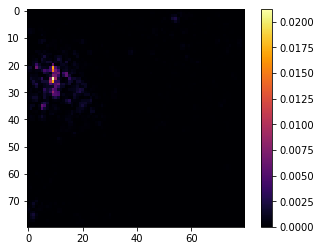

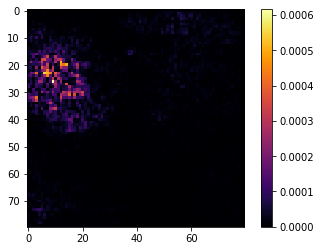

In [170]:
plt.imshow(np.abs(result[0][..., 0]), cmap="inferno")
plt.colorbar()
plt.figure()
plt.imshow(np.abs(result[0][..., 1]), cmap="inferno")
plt.colorbar()

In [209]:
(y1, y2), (x1, x2) = bounds[index]
print(bounds[index])

NameError: name 'bounds' is not defined

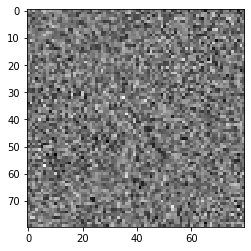

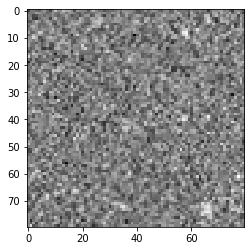

In [22]:
plt.imshow(normalize(sci[y1:y2, x1:x2], size*size), cmap="gray")
plt.figure()
plt.imshow(normalize(ref[y1:y2, x1:x2], size*size), cmap="gray")

In [49]:
predictions = np.zeros(sci.shape)
for pred in top_preds:
    (y1, y2), (x1, x2) = bounds[pred]
    predictions[y1:y2, x1:x2] += preds[pred]

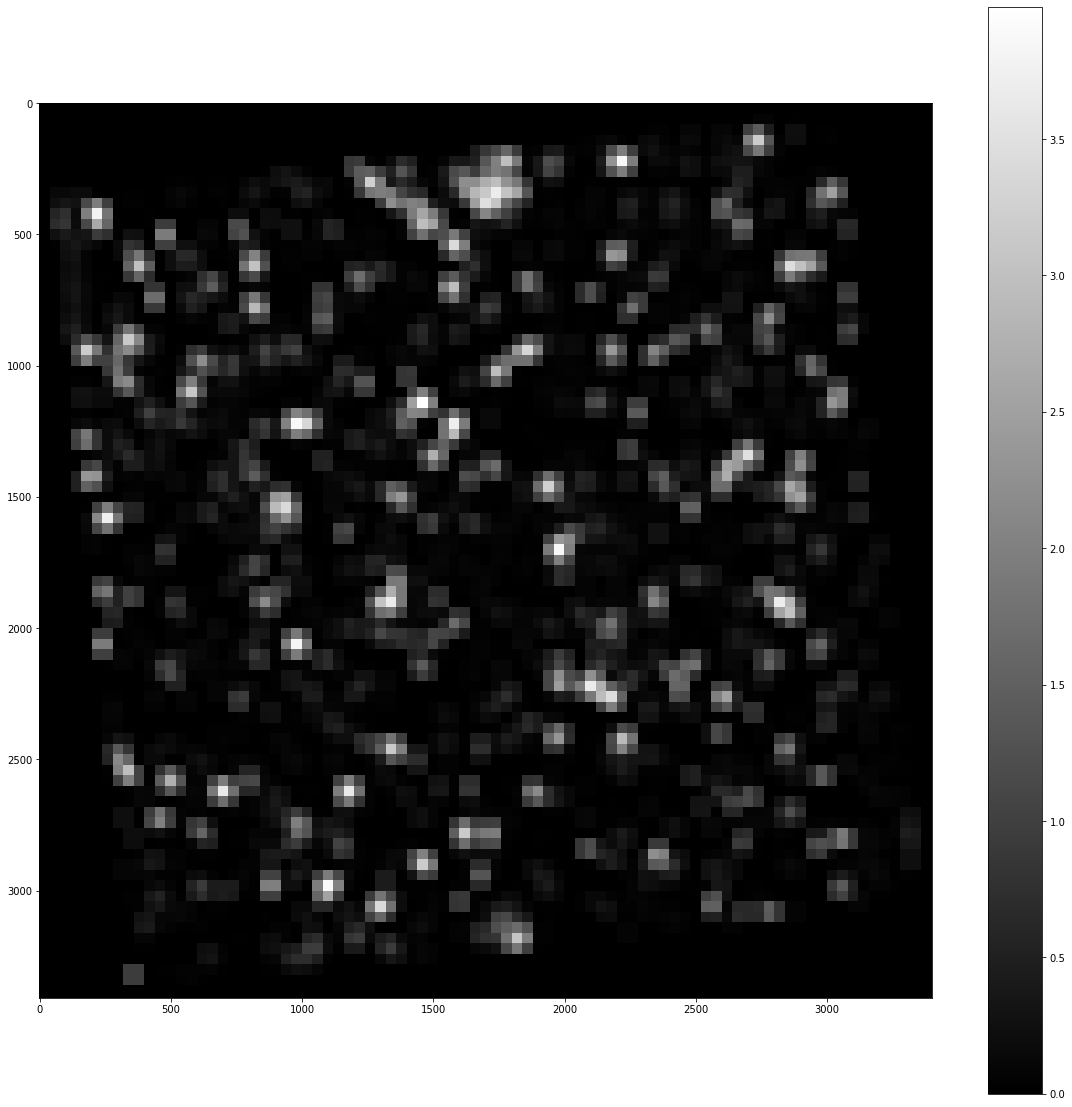

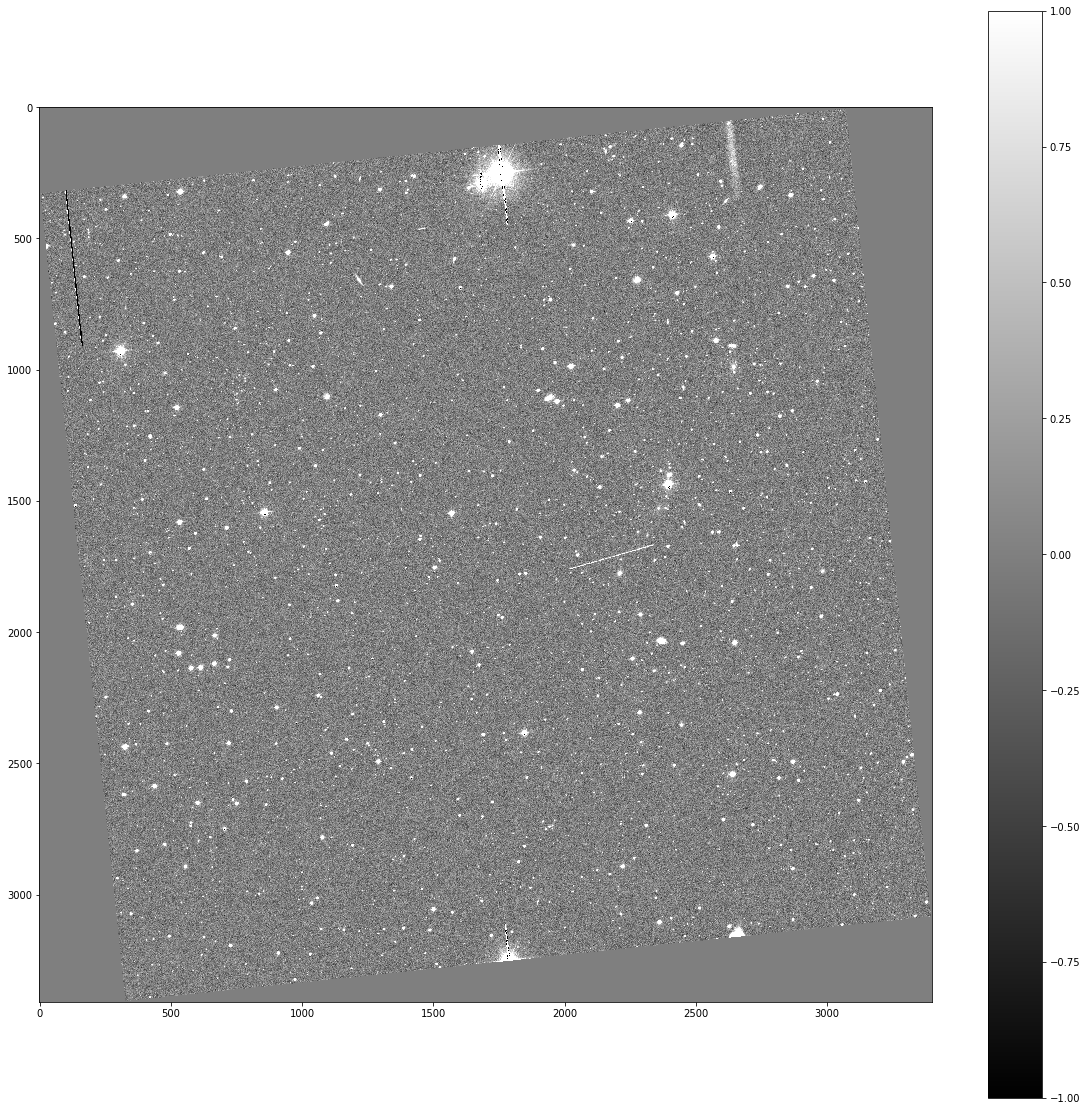

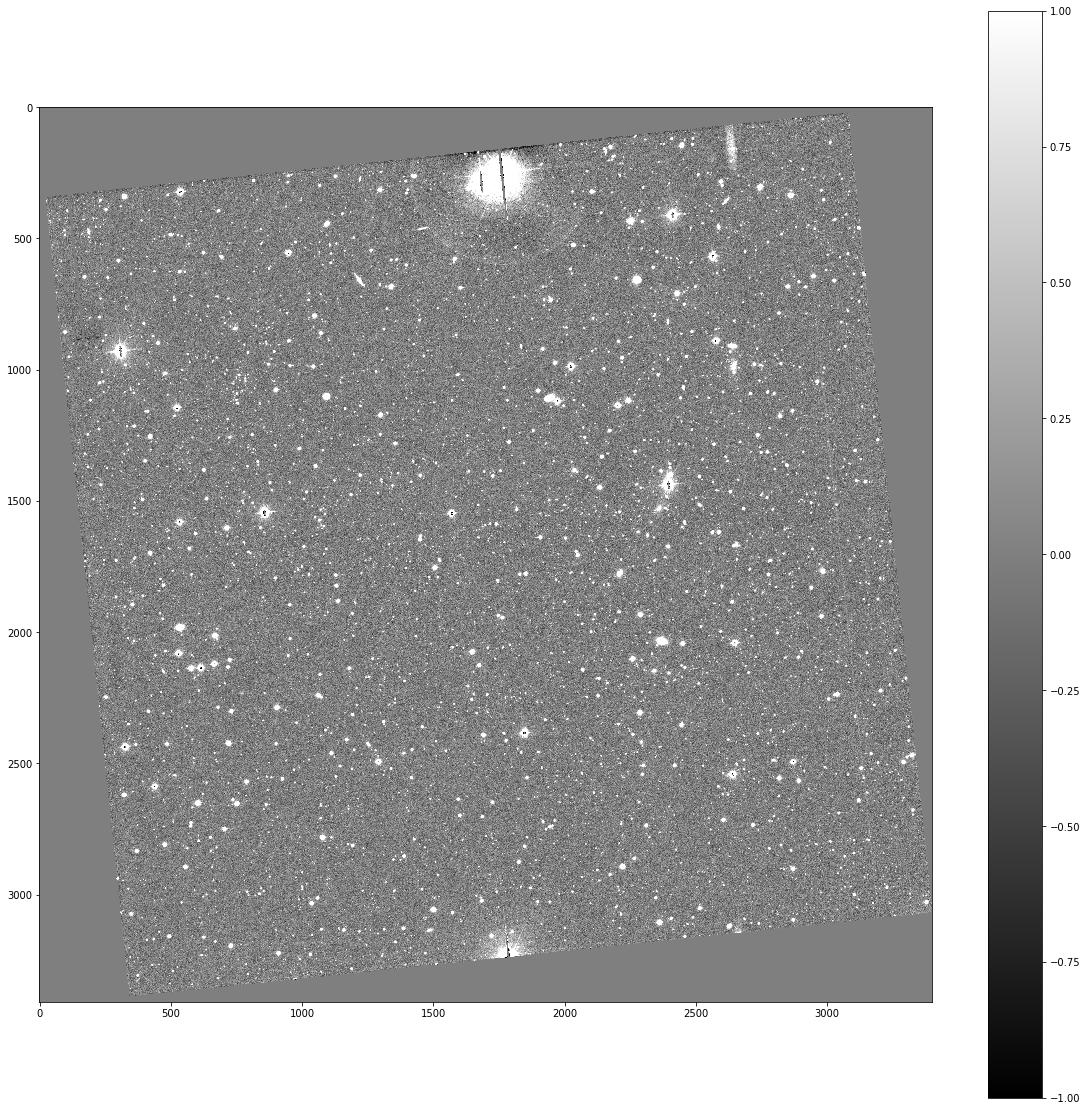

In [57]:
plt.figure(figsize=(20, 20))
plt.imshow(predictions, cmap="gray")
plt.colorbar()
plt.figure(figsize=(20, 20))
plt.imshow(normalize(sci, 20000), cmap="gray")
plt.colorbar()
plt.figure(figsize=(20, 20))
plt.imshow(normalize(ref, 20000), cmap="gray")
plt.colorbar()

In [ ]:
plt.imshow(images[677][..., 0], cmap="gray")
plt.figure()
plt.imshow(images[677][..., 1], cmap="gray")

In [8]:
y_len, x_len = sci.shape
images = []
bounds = []
for i in range(0, y_len, size):
    for j in range(0, x_len, size):
        crop_sci = sci[i:i+int(size*1.5), j:j+int(size*1.5)]
        crop_ref = ref[i:i+int(size*1.5), j:j+int(size*1.5)]
        
        if np.sum(crop_sci == 0) >= 200 or np.sum(crop_ref == 0) >= 200 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
            continue
        
        sci_norm = normalize(crop_sci, size * size // 2)
        ref_norm = normalize(crop_ref, size * size // 2)
        for x in range(0, size, size//2):
            for y in range(0, size, size//2):
                images.append([sci_norm[y:y+size, x:x+size], ref_norm[y:y+size, x:x+size]])
                bounds.append(((i + y, i + y + size), (j + x, j + x + size)))

KeyboardInterrupt: 

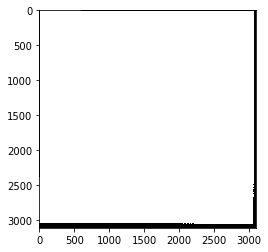

In [54]:
valid_pix = np.logical_and(np.logical_and(ref != 0, ~np.isnan(ref)), np.logical_and(sci != 0, ~np.isnan(sci)))
plt.imshow(valid_pix, cmap="gray")

In [270]:
%%timeit -n 1 -r 1
file = np.random.choice(filenames)
# print(file)
sci, ref = np.load(file)
y_len, x_len = sci.shape
images = []
bounds = []

for i in range(0, y_len, 50):
    for j in range(0, x_len, 50):
        if j + size >= x_len or i + size >= y_len:
            continue
        
        crop_sci = sci[i:i+size, j:j+size]
        crop_ref = ref[i:i+size, j:j+size]

        if np.sum(crop_sci == 0) >= 100 or np.sum(crop_ref == 0) >= 100 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
            continue

        sci_norm = normalize(crop_sci, size * size // 4)
        ref_norm = normalize(crop_ref, size * size // 4)
        images.append([sci_norm, ref_norm])
        bounds.append(((i, i + size), (j, j + size)))

11.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
def normalize_section(sci, ref, section, samples=size*size//16):
    (y1, y2), (x1, x2) = section
    
    crop_sci = sci[y1:y2, x1:x2]
    crop_ref = ref[y1:y2, x1:x2]
    
    if np.sum(crop_sci == 0) >= 100 or np.sum(crop_ref == 0) >= 100 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
        return None
            
    return normalize(crop_sci, samples), normalize(crop_ref, samples)

In [15]:
%%time
file = np.random.choice(filenames)
file = "/media/rd1/ztf_neos/training_examples/aligned/ztf_20180824406285_000297_zr_c13_o_q1_sciimg.resamp.fits.npy"
# print(file)
sci, ref = np.load(file)
y_len, x_len = sci.shape
bounds = []
normalize_section_partial = partial(normalize_section, sci, ref)

for i in range(0, y_len, 50):
    for j in range(0, x_len, 50):
        if j + size >= x_len or i + size >= y_len:
            continue
        
#         sci_norm = normalize(crop_sci, size * size // 4)
#         ref_norm = normalize(crop_ref, size * size // 4)
#         images.append([sci_norm, ref_norm])
        bounds.append(((i, i + size), (j, j + size)))
    
with Pool(2) as p:
    images = p.map(normalize_section_partial, bounds)

images = [image for image in images if image is not None]
images = np.array(images)
images = np.transpose(images, [0, 2, 3, 1])
preds = model.predict(images)
preds = preds[:, 0, 0, 0]

CPU times: user 59.3 s, sys: 9.59 s, total: 1min 8s
Wall time: 9.06 s


In [103]:
size = 80
contrast = 0.05
def linear_regression(X, Y, w, b, iterations, alphaN, weights):
    
#     print("Start")
#     print(w.shape)
#     print(X.shape)
#     print(b.shape)
#     print(Y.shape)
#     print(weights.shape)
    
    for i in range(iterations):
        diff = cp.multiply(cp.multiply(w, X) + b - Y, weights)
        w -= alphaN * cp.sum(cp.multiply(X, diff), axis=-1, keepdims=True)
        b -= alphaN * cp.sum(diff, axis=-1, keepdims=True)
#     print(w, b)
#     print(type(w), type(b))
#     print(np.sum((w*X + b - Y)**2))
    return w, b


def line_fit_2(x, y, weight):
    
    n_samples = cp.sum(weight, axis=-1, keepdims=True)
    
    alphaN = 0.000002/n_samples
    
    return linear_regression(y, x, 0, 0, 10, alphaN)


def weighted_std(values, weights):
    average = cp.expand_dims(cp.average(values, weights=weights, axis=-1), -1)
    # Fast and numerically precise:
    variance = cp.average((values-average)**2, weights=weights, axis=-1)
    return cp.sqrt(variance)


# for some reason CuPy just doesn't have median function
def get_median(arr):
    size = arr.shape[-1]
    return (arr[:, size//2] + arr[:, size//2 + 1]) / 2


def normalize_cuda(arr, nsamples):
    arr = cp.array(arr)
#     arr = cp.transpose(arr, [0, 3, 1, 2])
#     arr = cp.reshape(arr, (len(arr) * 2, size, size))
    
    values = cp.reshape(arr, (len(arr), size * size))
    stride = (size * size) // nsamples
    
    # need to do this since CuPy doesn't support sorting non-contiguous arrays
    samples = cp.array(values[::, ::stride][::, :nsamples])
#     print(samples.shape)
    samples.sort()
#     print(samples.shape)

    npix = nsamples
    nimage = len(arr)
    
    vmin = samples[:, 0]
    vmax = samples[:, -1]

    x = np.expand_dims(cp.arange(npix), 0)
    ngoodpix = npix

    # pixels mask used in k-sigma clipping
    goodpix = cp.ones((nimage, npix))
    
    slope = cp.zeros((nimage, 1))
    intercept = cp.zeros((nimage, 1))
    
    ngrow = max(1, int(npix * 0.01))
    kernel = cp.ones((1, ngrow))
    
    for niter in range(10):
        
        n_samples = cp.sum(goodpix, axis=-1, keepdims=True)

        alphaN = 0.000002/n_samples
        
        slope, intercept = linear_regression(x, samples, slope, intercept, 10, alphaN, goodpix)
#         fit = line_fit_2(x, samples, (goodpix).astype(int))
        
        fitted = slope * x + intercept

        # Subtract fitted line from the data array
        flat = samples - fitted

        # Compute the k-sigma rejection threshold
        threshold = cp.expand_dims(2.5 * weighted_std(flat, goodpix), -1)

        # Detect and reject pixels further than k*sigma from the
        # fitted line
        goodpix[(flat < - threshold) | (flat > threshold)] = 0

        goodpix = 1 - cp.clip(convolve(1 - goodpix, kernel), 0, 1)
        
    ngoodpix = cp.sum(goodpix, axis=-1)
    
    # can reduce back down to 1D
    slope = slope[:, 0]
    
    if contrast > 0:
        slope = slope / contrast
    center_pixel = (npix - 1) // 2
    median = get_median(samples)
    
    vmin = median - (center_pixel - 1) * slope
    vmax = median + (npix - center_pixel) * slope
    
#     vmin = max(vmin, median - (center_pixel - 1) * slope)
#     vmax = min(vmax, median + (npix - center_pixel) * slope)
    
    vmin = np.reshape(vmin, (len(arr), 1, 1))
    vmax = np.reshape(vmax, (len(arr), 1, 1))
    
    arr -= vmin
    arr /= vmax - vmin
    
    return cp.clip(arr, 0, 1)